# Varimax rotation of Empirical Orthogonal Functions

In preparation for this lecture, I asked you to read the article by [Dommenget and Latif (2002)](https://doi.org/10.1175/1520-0442(2002)015<0216:ACNOTI>2.0.CO;2) and you are also currently reading [Monahan et al. (2009)](https://doi.org/10.1175/2009JCLI3062.1).  It is important to be aware of both the benefits and potential limitations of EOF analysis so that we don't inadvertently interpret a feature of the mathematics as a true independent feature of the system.  In some cases our EOF analyses have led to straightforward isolation of real features in our data (country-level trends in cereals production, or leading patterns of variance in the tropical and North Pacific), but as Dommenget and Latif (2002) indicate, 'care that must be taken in the interpretation of individual modes in order to distinguish the medium from the message.'  Monahan et al. (2009) center their paper around the same idea, concluding 'In the analysis of atmo- spheric and oceanic variability, any statistical analysis must be interpreted with an eye toward structures imposed by both the underlying dynamics and the statis- tical tool itself in order to distinguish the medium from the message.'

Thus far we've seen orthogonality of the resulting eigenmodes to be an advantage.  But in their review paper, [Hannachi et al. (2007)](https://doi.org/10.1002/joc.1499) describe the problem thusly:

>The geometrical constraints characterising EOFs and PCs can be very useful in practice since the covariance matrix of any subset of retained PCs is always diagonal. These same constraints, however, can also be restrictive in other contexts. Take spatial orthogonality, for instance. Because it is a global property, the orthogonality constraint can cause the EOFs to have structures over most of the domain and with significant amplitude, when in fact one expects the patterns to be more localised. Horel (1981), for example, points out that if the first EOF has a constant sign over its domain then the second one will generally have both signs with the zero line going through the maxima of the first EOF. This also yields the problem of domain-dependence and non-locality (Horel, 1981; Richman, 1986, 1987). These problems can cause difficulties in interpreting the obtained patterns (Ambaum et al., 2001, 2002; Dommenget and Latif, 2002; Jolliffe et al., 2003) because physical modes are not necessarily orthogonal. Normal modes derived, for example, from linearised dynamical/physical models, such as barotropic models (Simmons et al., 1983) are not orthogonal since physical processes are not uncorrelated.

In otherwords, there are features of the systems we are studying that are not expected to be uncorrelated and may be highly localized, not global as typically emerges from EOF analysis.  And as [Horel (1981)](https://doi.org/10.1175/1520-0493(1981)109<2080:ARPCAO>2.0.CO;2) pointed out long ago, if the leading pattern emerging from EOF has the same sign everywhere in the spatial domain, the second mode will be likely be a dipole, by virtue of the mathematics alone! 

Rotation of EOFs (REOF) 'relaxes' some of the features or requirement that we've discussed thus far in order to extract non-orthogonal localized features from our data that are potentially more easily interpreted in terms of the system we are studying.   As Hannachi et al (2007) describe:

>The REOF method yields in general localised structures by compromising some of the EOFs' geometric properties such as orthogonality. Rotation attempts to yield simpler patterns than EOFs.

[Mestes-Nunez (2000)](https://doi.org/10.1002/1097-0088(200010)20:12%3C1509::AID-JOC553%3E3.0.CO;2-Q) notes that the type of rotations that preserve temporal orthogonality (uncorrelatedness) but relax the spatial (eigenvector) orthogonality can be particularly useful when making inferences about true spatial patterns in the data:

> (when) orthogonality is preserved in time, but relaxed in space ... this choice is useful to avoid getting predictable space patterns for the second and higher modes when the leading space pattern is known. 

I give a very cartoon example in lecture, but here we'll see in this notebook a real world application as well as the coding machinery to do it.  Rotation of EOF is not necessarily a panacea that solves all problems.  Whether interpreting un-rotated or rotated EOFs, it is important to be aware, as Monahan et al. (2009) write that the 'mathematical details are not incidental to the results of EOF analysis; in fact ... they are central.'  Rotating or not each carry potential insights into the structure of our data and the potential to use this knowledge for inference or to reduce the dimensions of our problem.  


## Doing varimax rotated EOF Analysis

To begin, let's get our packages loaded - much of the mathematics we'll want to do will come from Numpy, but we'll also want to plot our results on maps, so we'll bring in Matplotlib and Cartopy as well:

In [15]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# we'll use the following command to exert greater control over colorbar placement
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

# nicely render figures in the notebook 
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Cartopy gives a lot of warnings when downloading map data, which we'll suppress
import warnings
warnings.filterwarnings("ignore") 

# you can omit the line below if you'd like, but I really don't like the default fonts in Python, so I switch to Helvetica
plt.rcParams['font.family'] = 'Helvetica'

# import cartopy 
import cartopy # base Cartopy
import cartopy.crs as ccrs # shortcut to the coordinate reference system
import cartopy.feature as cfeature # add map features

Here we will focus on a type of rotation called a **varimax** rotation ([Kaiser 1958](https://doi.org/10.1007/BF02289233)).  Varimax attempts to do its 
simplification of the EOF patterns by iteratively finding new loadings that are either all close to zero or close to 1 (or, maximizing the number of either small or large values).  This creates the localization effect described above.  Varimax is an orthogonal rotation, which means that the transformation matrix (often designated as **R** or **T**) for rotation is itself orthogonal, $\mathbf{T'T=I}$).  This does not mean the rotated eigenvectors or resulting PCs will retain the property of orthogonality or un-correlatedness!  In fact, as [Jolliffe (1995)](https://doi.org/10.1080/757584395) writes (and a point we'll return to later in this notebook):

> "It is a frequent misconception that orthogonal rotation will produce rotated components which are pairwise uncorrelated, and/or whose loadings are orthogonal In fact, it is not possible, using the standard definition of rotation, to preserve both these properties."

Here we seek a new set of rotated EOFs (REOF) that is the outcome of some subset $m$ of our EOFs $U_{m}$ transformed by a rotation matrix **T**:

$
B = U_{m}\mathbf{T}
$

where $B$ is our REOF matrix, $m$ is the number of EOFs chosen for rotation, and $U_{m}$ indicates the subset of our original EOFs that we selected for rotation.  

Varimax rotation specifically maximises the following criterion for 'simplifying' the EOF loadings:

$
\max \left(\sum_{k=1}^m\left[p \sum_{j=1}^p b_{j k}^4-\left(\sum_{j=1}^p b_{j k}^2\right)^2\right]\right)
$

where $m$ is again the number of EOFs chosen for rotation, $j = 1,...m$, and $p$ is the number of observations, so $i = 1,...p$.  If you look closely,  the equation essentially tell us about the variance of the squared loadings (of the rotated EOFs), a condition which should be maximized when the loadings are either 0 or 1 (Kaiser 1958). If you're interested in more of the math, there is [Kaiser 1958](https://doi.org/10.1007/BF02289233) as well as [Richman (1986)](https://doi.org/10.1002/joc.3370060305). The trick now is how to maximize this criterion!  

Let's write a Python function to do varimax rotation for us.  The approach to efficiently solving the maximization problem here is based on [Lawley and Maxwell (1962)](https://doi.org/10.2307/2986915).  The function proceeds as follows:  After getting the size of the matrix containing the subset of EOFs we wish to rotate and setting the gamma parameter, we initialize with a naive first guess for the rotation matrix **T** as the identity matrix **I**, and our first guess at the REOFs are then simply the dot product of the EOFs we selected to rotate and the first guess rotation matrix.  We then begin to iterate (also setting some maximum number of iterations).  We calculate the variance of the squared loadings for each REOF mode.  The rotation itself starts with the singular value decomposition of the dot product of our original EOFs and the current REOFs raised to the third power less the dot product of the REOFs and the variance of their squared loadings.  The new rotation matrix estimate is the dot product of the eigenvectors of that svd.  REOFs are then re-calculated from the dot product of the original EOFs and that new rotation matrix.  The sum of the eigenvalues from the svd are are compared with the previous values (originally set to zero so the iteration through the loop runs at least once) and if the normalized difference in the previous iteration and new iteration are small enough ('enough' set by some very small relative tolerance number), the loop completes and we have our new REOFs: 

### Varimax rotation function

In [16]:
def varimax_rotation(A, reltol=1e-9, itermax=1000, normalize=False):
    # following Lawley and Maxwell (1962)
  
    if normalize: # this is the 'Kaiser normalization', not the pre-normalization we were talking about above
        h = np.sqrt(np.sum(A**2, axis=1))
        A = A / h[:, np.newaxis]

    # get the size of the selected eigenvectors matrix
    nrows, ncol = A.shape
    
    # set the gamma value for varimax
    gamma = 1.0 
    
    # this is the initial rotation matrix, T, which starts simply as the identity matrix
    T = np.eye(ncol) 
    
    # first 'rotation' is just the dot product of the loadings and the identity matrix
    B = np.dot(A, T) 
    
    var_new = 0
    converged = False

    for k in range(1, itermax + 1): # iterations can be up to itermax
        
        # set the prior variance to the previous step
        var_prior = var_new
        
        # svd of the dot product of the unroated EOFs and the variance of the squared loadings of the current REOF 
        U, S, V = np.linalg.svd(np.dot(A.T, (nrows * B**3 - gamma * B @ np.diag(np.sum(B**2, axis=0)))))
        
        # recalculate the rotation matrix as the dot product of the eigenvectors 
        T = np.dot(U, V)
        
        # the new variance metric is the sum of the diagonals of S
        var_new = np.sum(S)
        
        # recalculate the REOFs as the dot product of the EOFs and new rotation matrix
        B = np.dot(A, T)
        
        # if we are now below the relative tolerance, exit and report the values
        if abs(var_new - var_prior) / var_new < reltol:
            break
    
    # Unnormalize the rotated loadings if necessary
    if normalize:
        B = B * h[:, np.newaxis]
    
    return B, T


Let's read in some data to use with our new varimax rotation code.   This is a csv file with 116 tree-ring sites from across the Mediterranean region.  I've extracted just the modern period from each one (since 1850).  There is a second csv with the longitude and latitude coordinates for each site. We'll read in both using Pandas: 

In [17]:
df1 = pd.read_csv("mediterranean_trees_modern_segment.csv",index_col=0)
df2 = pd.read_csv("mediterranean_trees_coords.csv")

For simplicity, let's find all the columns (tree-ring sites) that are complete over the full time period so we don't have to deal with missing data, imputation, or interpolation here.  We'll extract just those columns and then also trim the matching coordinates DataFrame to only those sites as well.  

[[1. 1.]
 [1. 1.]]


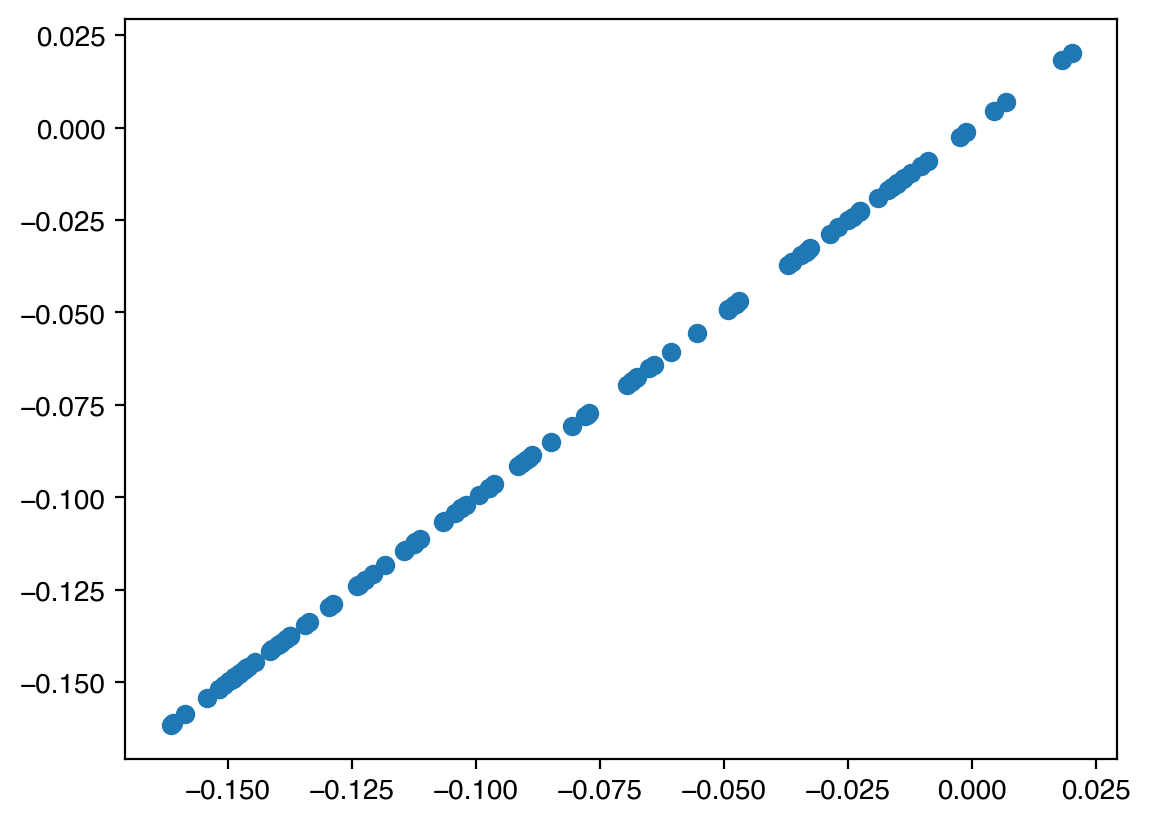

In [18]:
all_available = df1.isnull().sum()==0
df1 = df1.loc[:,all_available].copy()
df2 = df2.loc[all_available.values.tolist(),:] # because we're going from columns (with names) to rows (without variable names) we need to use .values.tolist()

# now pull out what we want into arrays
trees = np.asarray(df1) # year, site
coords = np.asarray(df2) # lon, lat

# remove the mean from the tree ring data and standardize to a standard deviation of 1
trees = (trees - np.mean(trees))/np.std(trees)

# get the correlation matrix
C = np.corrcoef(trees,rowvar=False,ddof=1)

# since this is a reasonably sized dataset, we can get eigenvectors and eigenvalues from np.linalg.svd
U,S,V = np.linalg.svd(C)

# but, let's do it with Scipy too, just to convince ourselves we get the same answer
Ux,Sx,Vx= sp.sparse.linalg.svds(C,k=2)

# remember that Scipy's svd output won't necessarily be from largest to smallest eigenvalue, so sort everything so that it is
sort_index = np.argsort(Sx)[::-1] # sort in descending order from highest to lowest value
Sx = Sx[sort_index] # apply the sort index to the eigenvalues
Ux = Ux[:,sort_index] # apply the index to the ordering of the eigenvector columns

# Sanity check! Prove to yourself that sp.sparse.linalg.svds gives the same output as np.linalg.svd and where in each eigenvector matrix these are
plt.scatter(U[:,0],Ux[:,0])
print(np.corrcoef((U[:,0],Ux[:,0]))) # perfectly correlated, as they should be



OK, let's make a map of our EOF1 and EOF2 loadings at each of our tree-ring locations:

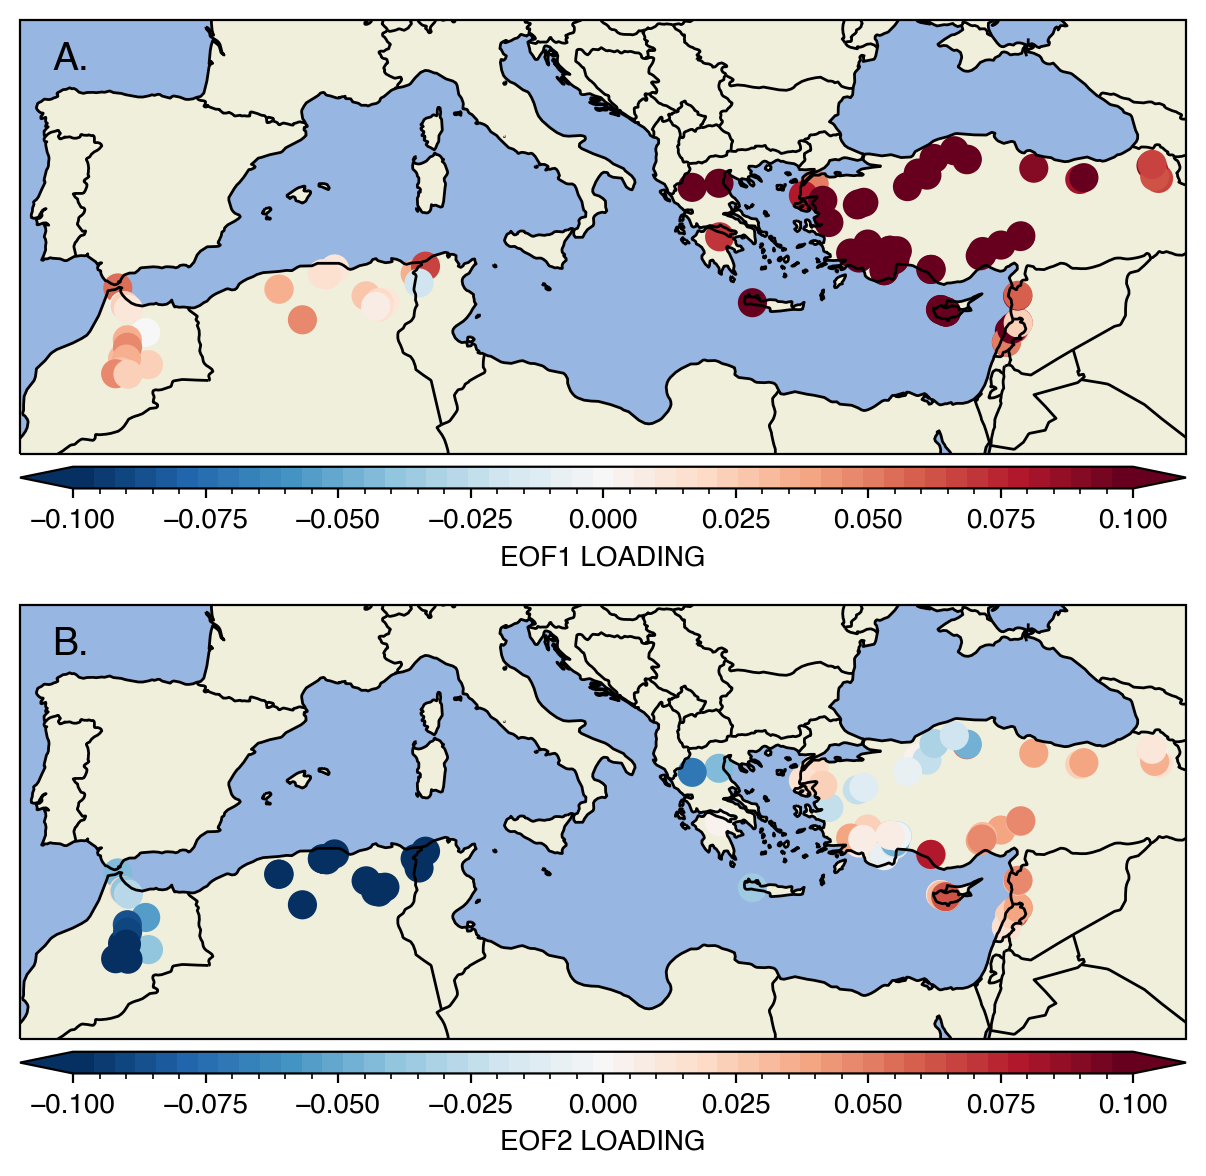

In [19]:
# map extent of the Mediterranean again
latN = 43.0
latS = 29.0
lonW = -10.0
lonE = 44.0
cLon = (lonW + lonE )/2

# some plot settings
res = '50m' # resolution to use for Natural Earth features via Cartopy
proj = ccrs.Miller(central_longitude=cLon) # projection

# setup figure with two rows of subplots
fig, (ax1,ax2) = plt.subplots(num=1, figsize=(10,6), clear=True, nrows=2,ncols=1,subplot_kw={'projection': proj})

ax1.set_extent([lonW,lonE,latS,latN])
ax1.add_feature(cfeature.LAND.with_scale(res))
ax1.add_feature(cfeature.OCEAN.with_scale(res))
ax1.add_feature(cfeature.COASTLINE.with_scale(res))
ax1.add_feature(cfeature.BORDERS,edgecolor='black')
cmap = plt.cm.get_cmap('RdBu_r', 51)
exs1 = ax1.scatter(x=coords[:,0],y=coords[:,1],s=90,c=-U[:,0],transform=ccrs.PlateCarree(),vmin=-0.1,vmax=0.1,cmap=cmap); # now the scatter plot is of the loadings at each site!
ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("bottom", size="5%", pad="3%",axes_class=mpl.axes.Axes)
cb1 = plt.colorbar(exs1, orientation='horizontal',label='EOF1 LOADING',extend='both',shrink=0.6,cax=cax1)
cb1.minorticks_on()
ax1.text(-8.5, 45.5, 'A.', transform=ccrs.PlateCarree(), fontsize=14, verticalalignment='top')

ax2.set_extent([lonW,lonE,latS,latN])
ax2.add_feature(cfeature.LAND.with_scale(res))
ax2.add_feature(cfeature.OCEAN.with_scale(res))
ax2.add_feature(cfeature.COASTLINE.with_scale(res))
ax2.add_feature(cfeature.BORDERS,edgecolor='black')
cmap = plt.cm.get_cmap('RdBu_r', 51)
exs2 = ax2.scatter(x=coords[:,0],y=coords[:,1],s=90,c=-U[:,1],transform=ccrs.PlateCarree(),vmin=-0.1,vmax=0.1,cmap=cmap); # now the scatter plot is of the loadings at each site!
ax2_divider = make_axes_locatable(ax2)
cax2 = ax2_divider.append_axes("bottom", size="5%", pad="3%",axes_class=mpl.axes.Axes)
cb2 = plt.colorbar(exs2, orientation='horizontal',label='EOF2 LOADING',extend='both',shrink=0.6,cax=cax2)
cb2.minorticks_on()
ax2.text(-8.5, 45.5, 'B.', transform=ccrs.PlateCarree(), fontsize=14, verticalalignment='top')

plt.tight_layout()

Like, ok, but meh.  The first EOF is pretty much the same sign everywhere, although it hints maybe at a common pattern of variability popping out in the eastern Mediterranean, especially Greece and Turkey.  The second EOF mode, as we might expect, is a dipole, but we might have trouble interpreting it - are the tree-ring chronologies in Cyprus really behaving in the exact opposite manner as the Atlas Mountains in a way that we would want to interpret ecologically or climatologically? Can we interpret this dipole pattern of tree growth as meaningful beyond the mathematics of the EOF procedure?  This is a situation where we would want to at the very least check the rotated EOFs, to see if they provide any additional or simplified information about the structure of the covariance in our system.  

Let's do it!

## Rotated EOF Analysis

First, let's set a variable for the number to rotate.  Because varimax seeks to maximize the simplicity of the eigenvector matrix, your _selection_ (remember signiicance testing?) of how many eigenvectors to rotate will have an effect on the resulting REOFs

In [20]:
# set the number of eigenvectors to rotate
numberToRotate = 3 

# create a subset of the eigenvectors and put them in the array called A
A = U[:,0:numberToRotate] 

### Normalization, orthogonality, and uncorrelatedness

Now, several words on normalization or pre-scaling (or not!) of the EOFs prior to rotation. First, to quote [Abdel Hannachi](https://doi.org/10.1002/joc.1243):

> "Any (non-trivial) orthogonal rotation of EOFs cannot conserve both the spatial orthogonality and temporal uncorrelatedness"

Mestes-Nunez (2000), '[Orthogonality properties of rotated empirical modes](https://doi.org/10.1002/1097-0088(200010)20:12%3C1509::AID-JOC553%3E3.0.CO;2-Q)' is a good resource on this issue.  He also writes:

> "An aspect of rotation that has lead to some apparent confusion in the literature concerns the orthogonality properties of orthogonally rotated empirical modes. This applies to varimax, as well as other orthogonal rotations. Jolliffe (1995) showed that it is impossible to preserve both spatial orthogonality and temporal uncorrelatedness of the modes after an orthogonal rotation"

And finally, to emphasize this point, here is [Ian Jolliffe](https://www.tandfonline.com/doi/abs/10.1080/757584395) himself:

> "It is a frequent misconception that orthogonal rotation will produce rotated components which are pairwise uncorrelated, and/or whose loadings are orthogonal In fact, it is not possible, using the standard definition of rotation, to preserve both these properties. Which of the two properties is preserved depends on the normalization chosen for the loadings, prior to rotation. The usual 'default' normalization leads to rotated components which possess neither property."

So in doing varimax rotation we're going to lose at least one (or maybe both) of the features that we previously identified as desireable - either EOFs will no longer be orthogonal, or the PC time series will no long be uncorrelated, or potentially both. Pre-scaling of the EOFs matters for the characteristics of the resulting rotated EOFs.  You have a few choices when it comes to scaling:

* No scaling at all before rotation.  This will give you REOFs that are still orthogonal, but signals that are have non-zero correlation
* Scaling by multipling by the square root of the eigenvalue will give you REOFs that are NOT orthogonal and signals that are have non-zero correlation
* Scaling by dividing by the square root of the eigenvalue will give you will give you REOFs that are NOT orthogonal, but signals that are NOT correlated

In [21]:
## EOF pre-scaling

# option 1, no scaling - returns REOFs that are orthogonal but time series will now be correlated - Mestes-Nunez (2000) calls this 'EOF mode'
# A = A

# option 2, multiply by the square root of the eigenvalues - Mestes-Nunez (2000) calls this 'PCA mode' = preserves neither characteristic
A = A * np.sqrt(S[0:numberToRotate])  

# option 3, divide by the square root of the eigenvalues - signals remain uncorrelated - this is 'an unusual case' as Mestes-Nunez (2000) says
# A = A / np.sqrt(S[0:numberToRotate]) 

### The outcomes and effects of varimax rotation

Let's now run the function we built above on our selected and potentially scaled eigenvectors:

In [22]:
# run our internal function for varimax rotation on the selected scaled EOFs:
reofs, rotation_matrix = varimax_rotation(A,normalize=True)

Let's see what we got! 

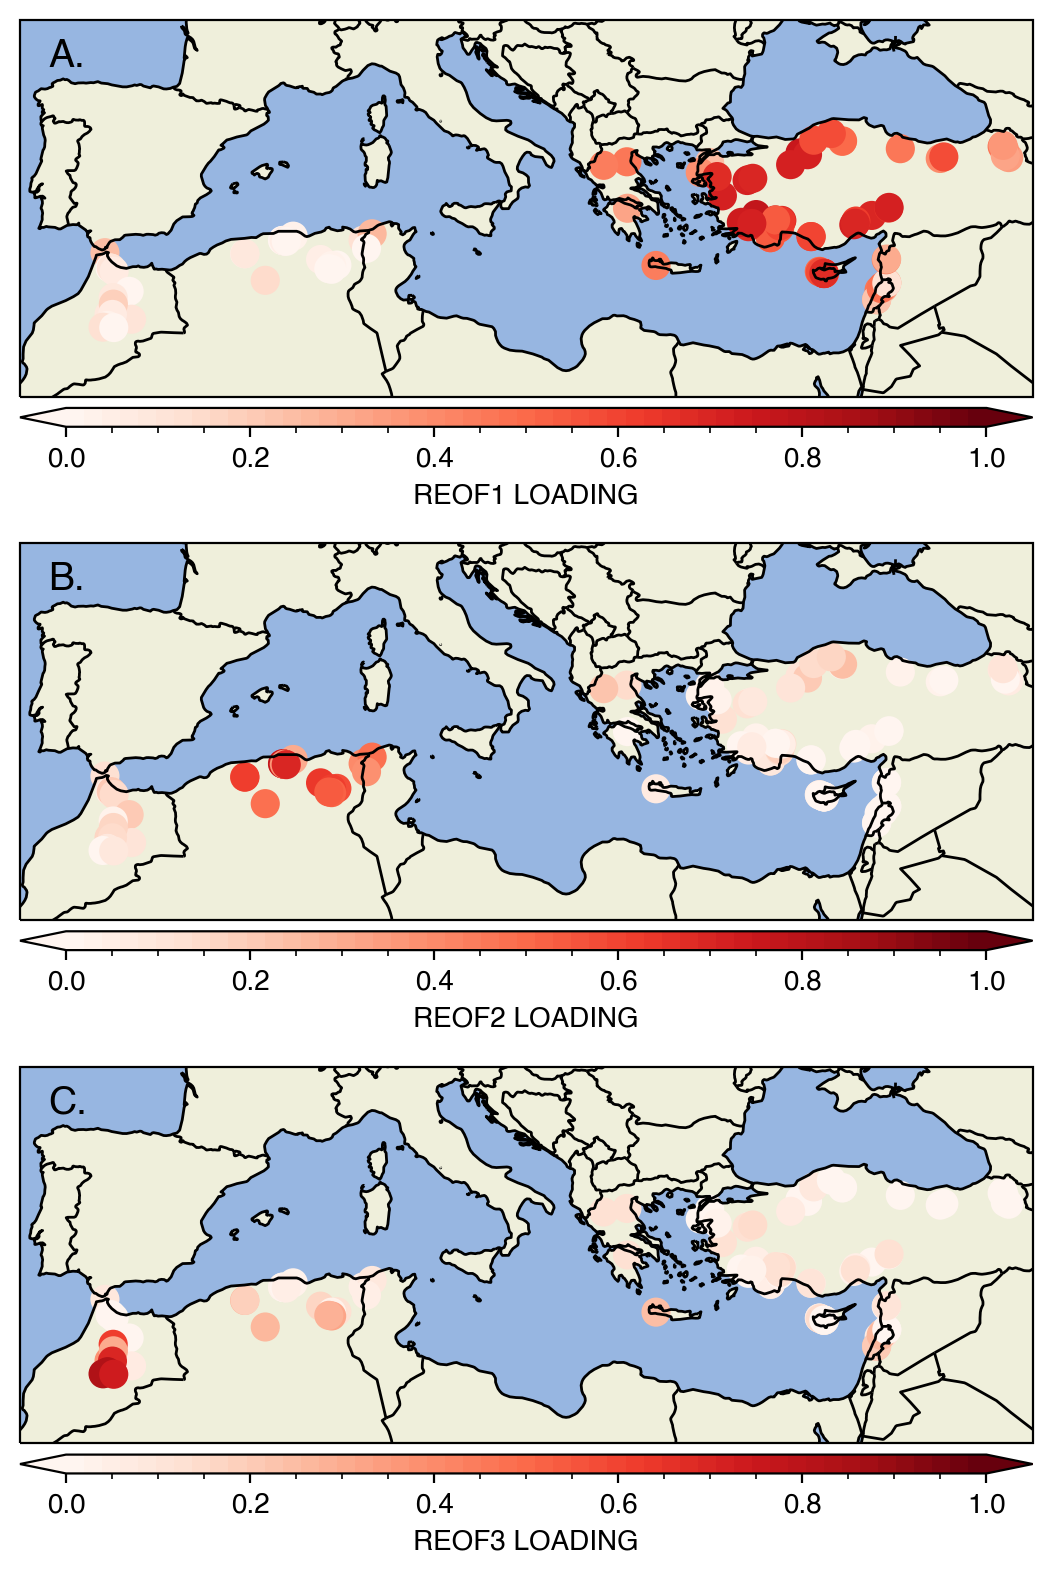

In [23]:
# map extent of the Mediterranean again
latN = 43.0
latS = 29.0
lonW = -10.0
lonE = 44.0
cLon = (lonW + lonE )/2

#
vmin = 0
vmax = 1

# some plot settings
res = '50m' # resolution to use for Natural Earth features via Cartopy
proj = ccrs.Miller(central_longitude=cLon) # projection

# setup figure with two rows of subplots
fig, (ax1,ax2,ax3) = plt.subplots(num=1, figsize=(12,8), clear=True, nrows=3,ncols=1,subplot_kw={'projection': proj})

ax1.set_extent([lonW,lonE,latS,latN])
ax1.add_feature(cfeature.LAND.with_scale(res))
ax1.add_feature(cfeature.OCEAN.with_scale(res))
ax1.add_feature(cfeature.COASTLINE.with_scale(res))
ax1.add_feature(cfeature.BORDERS,edgecolor='black')
cmap = plt.cm.get_cmap('Reds', 51)
exs1 = ax1.scatter(x=coords[:,0],y=coords[:,1],s=90,c=-reofs[:,0],transform=ccrs.PlateCarree(),cmap=cmap,vmin=vmin,vmax=vmax); # now the scatter plot is of the loadings at each site!
ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("bottom", size="5%", pad="3%",axes_class=mpl.axes.Axes)
cb1 = plt.colorbar(exs1, orientation='horizontal',label='REOF1 LOADING',extend='both',shrink=0.6,cax=cax1)
cb1.minorticks_on()
ax1.text(-8.5, 45.5, 'A.', transform=ccrs.PlateCarree(), fontsize=14, verticalalignment='top')

ax2.set_extent([lonW,lonE,latS,latN])
ax2.add_feature(cfeature.LAND.with_scale(res))
ax2.add_feature(cfeature.OCEAN.with_scale(res))
ax2.add_feature(cfeature.COASTLINE.with_scale(res))
ax2.add_feature(cfeature.BORDERS,edgecolor='black')
cmap = plt.cm.get_cmap('Reds', 51)
exs2 = ax2.scatter(x=coords[:,0],y=coords[:,1],s=90,c=reofs[:,1],transform=ccrs.PlateCarree(),cmap=cmap,vmin=vmin,vmax=vmax); # now the scatter plot is of the loadings at each site!
ax2_divider = make_axes_locatable(ax2)
cax2 = ax2_divider.append_axes("bottom", size="5%", pad="3%",axes_class=mpl.axes.Axes)
cb2 = plt.colorbar(exs2, orientation='horizontal',label='REOF2 LOADING',extend='both',shrink=0.6,cax=cax2)
cb2.minorticks_on()
ax2.text(-8.5, 45.5, 'B.', transform=ccrs.PlateCarree(), fontsize=14, verticalalignment='top')

ax3.set_extent([lonW,lonE,latS,latN])
ax3.add_feature(cfeature.LAND.with_scale(res))
ax3.add_feature(cfeature.OCEAN.with_scale(res))
ax3.add_feature(cfeature.COASTLINE.with_scale(res))
ax3.add_feature(cfeature.BORDERS,edgecolor='black')
cmap = plt.cm.get_cmap('Reds', 51)
exs3 = ax3.scatter(x=coords[:,0],y=coords[:,1],s=90,c=reofs[:,2],transform=ccrs.PlateCarree(),cmap=cmap,vmin=vmin,vmax=vmax); # now the scatter plot is of the loadings at each site!
ax3_divider = make_axes_locatable(ax3)
cax3 = ax3_divider.append_axes("bottom", size="5%", pad="3%",axes_class=mpl.axes.Axes)
cb3 = plt.colorbar(exs2, orientation='horizontal',label='REOF3 LOADING',extend='both',shrink=0.6,cax=cax3)
cb3.minorticks_on()
ax3.text(-8.5, 45.5, 'C.', transform=ccrs.PlateCarree(), fontsize=14, verticalalignment='top')


plt.tight_layout()

### Checking orthogonality

Remember that the dot product of a set of vectors will be zero if the vectors are orthogonal, so we can quickly check this on our REOFs:

In [24]:
reofs.T @ reofs # check orthogonality - if we scaled, we lose orthogonality

array([[22.67640461, -1.46688061, -2.1741649 ],
       [-1.46688061,  7.22503448,  0.93676504],
       [-2.1741649 ,  0.93676504,  5.82653685]])

### The rotated PCs

We calculate the rotated PCs the same way we did the unrotated PCs, but projecting now the REOFs on the centered data matrix. 

In [25]:
# this is how we get the time series for the rotated modes:
rpcs = trees @ reofs;

# check correlation of the time series
np.corrcoef(rpcs,rowvar=False)

array([[ 1.        , -0.27055123, -0.44122203],
       [-0.27055123,  1.        ,  0.32982126],
       [-0.44122203,  0.32982126,  1.        ]])

What happens if we only rotate 2 modes though?  Remember, the choice of how many modes to rotate can affect the outcome!

In [26]:
# set the number of eigenvectors to rotate
numberToRotate = 2

# create a subset of the eigenvectors and put them in the array called A
A = U[:,0:numberToRotate] 

# option 2, multiply by the square root of the eigenvalues - Mestes-Nunez (2000) calls this 'PCA mode' = preserves neither characteristic
A = A * np.sqrt(S[0:numberToRotate])  

# run our internal function for varimax rotation on the selected scaled EOFs:
reofs2, rotation_matrix = varimax_rotation(A,normalize=True)

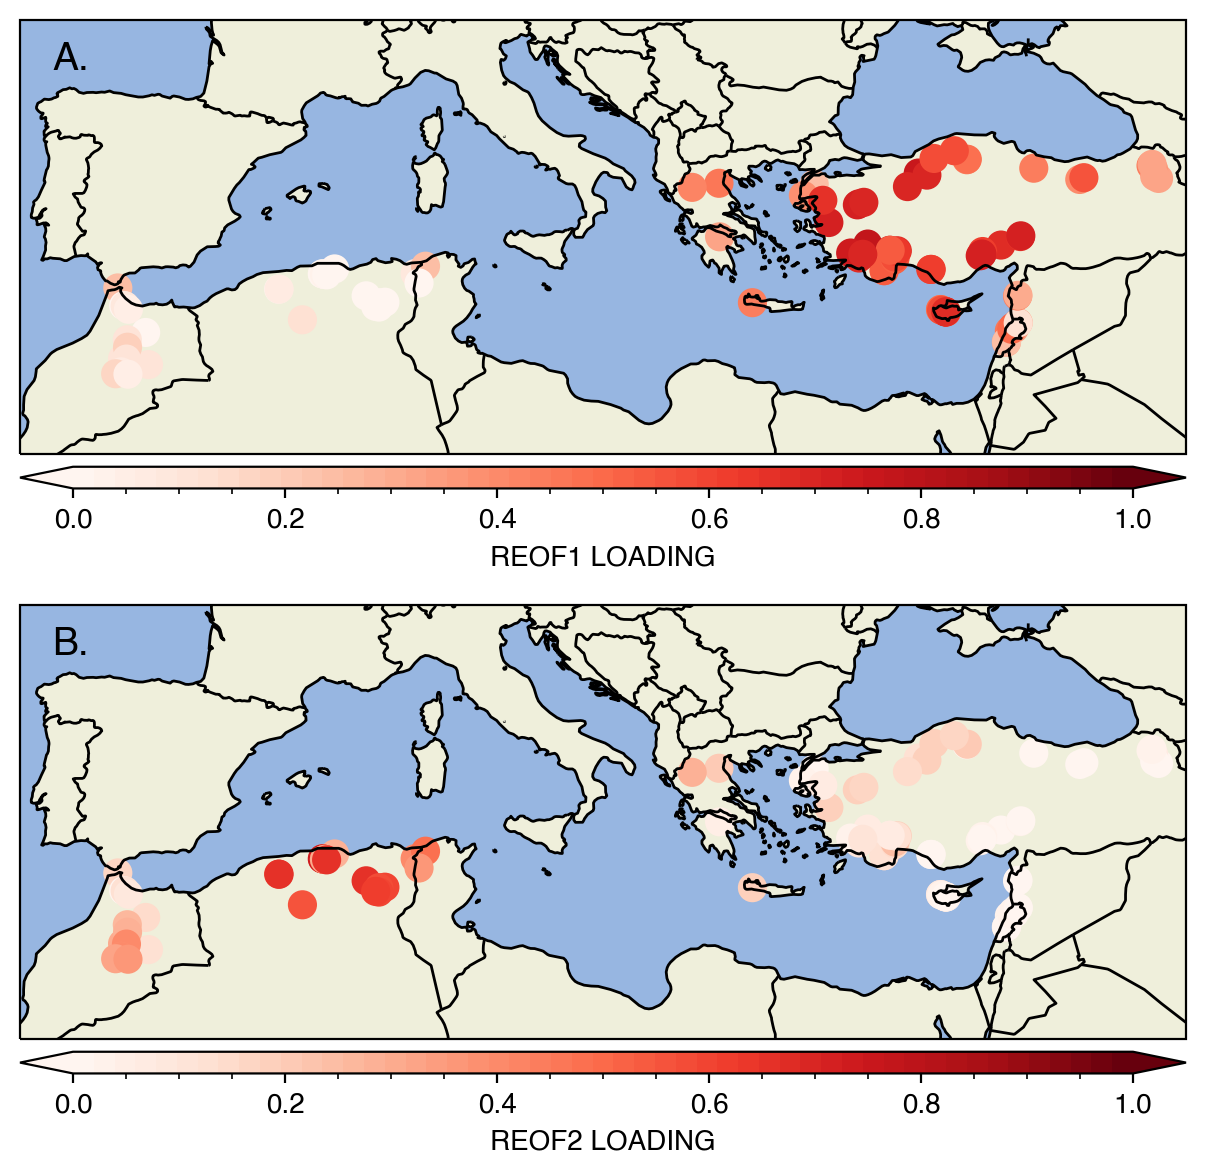

In [27]:
# map extent of the Mediterranean again
latN = 43.0
latS = 29.0
lonW = -10.0
lonE = 44.0
cLon = (lonW + lonE )/2

#
vmin = 0
vmax = 1

# some plot settings
res = '50m' # resolution to use for Natural Earth features via Cartopy
proj = ccrs.Miller(central_longitude=cLon) # projection

# setup figure with two rows of subplots
fig, (ax1,ax2) = plt.subplots(num=1, figsize=(10,6), clear=True, nrows=2,ncols=1,subplot_kw={'projection': proj})

ax1.set_extent([lonW,lonE,latS,latN])
ax1.add_feature(cfeature.LAND.with_scale(res))
ax1.add_feature(cfeature.OCEAN.with_scale(res))
ax1.add_feature(cfeature.COASTLINE.with_scale(res))
ax1.add_feature(cfeature.BORDERS,edgecolor='black')
cmap = plt.cm.get_cmap('Reds', 51)
exs1 = ax1.scatter(x=coords[:,0],y=coords[:,1],s=90,c=-reofs2[:,0],transform=ccrs.PlateCarree(),cmap=cmap,vmin=vmin,vmax=vmax); # now the scatter plot is of the loadings at each site!
ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("bottom", size="5%", pad="3%",axes_class=mpl.axes.Axes)
cb1 = plt.colorbar(exs1, orientation='horizontal',label='REOF1 LOADING',extend='both',shrink=0.6,cax=cax1)
cb1.minorticks_on()
ax1.text(-8.5, 45.5, 'A.', transform=ccrs.PlateCarree(), fontsize=14, verticalalignment='top')

ax2.set_extent([lonW,lonE,latS,latN])
ax2.add_feature(cfeature.LAND.with_scale(res))
ax2.add_feature(cfeature.OCEAN.with_scale(res))
ax2.add_feature(cfeature.COASTLINE.with_scale(res))
ax2.add_feature(cfeature.BORDERS,edgecolor='black')
cmap = plt.cm.get_cmap('Reds', 51)
exs2 = ax2.scatter(x=coords[:,0],y=coords[:,1],s=90,c=reofs2[:,1],transform=ccrs.PlateCarree(),cmap=cmap,vmin=vmin,vmax=vmax); # now the scatter plot is of the loadings at each site!
ax2_divider = make_axes_locatable(ax2)
cax2 = ax2_divider.append_axes("bottom", size="5%", pad="3%",axes_class=mpl.axes.Axes)
cb2 = plt.colorbar(exs2, orientation='horizontal',label='REOF2 LOADING',extend='both',shrink=0.6,cax=cax2)
cb2.minorticks_on()
ax2.text(-8.5, 45.5, 'B.', transform=ccrs.PlateCarree(), fontsize=14, verticalalignment='top')

plt.tight_layout()

Does this affect the RPCs, since the REOF matrix is different for 2 vs. 3 ?  Somewhat, although in this case not severely -- we can plot the 2nd RPC time series from both the 2- and 3 EOF rotation and see:

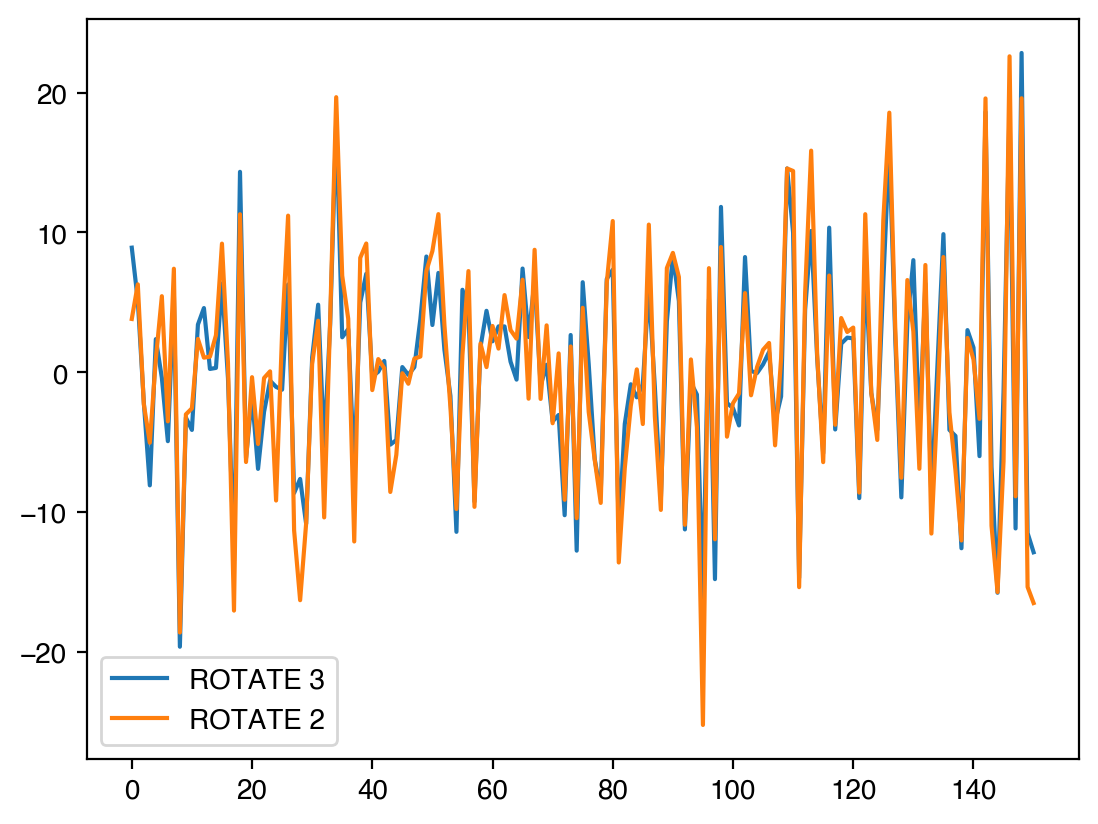

In [28]:
rpcs2 = trees @ reofs2; # time series for REOF with only 2 eigenvectors rotated

# compare the resulting time series for the 2nd rotated mode
plt.plot(rpcs[:,1],label='ROTATE 3')
plt.plot(rpcs2[:,1],label='ROTATE 2')
plt.legend()